# Text Mining for ESG Score Analysis & Prediction : Using News data

#Import libraries

In [1]:
import sklearn
import random
import numpy as np
import pandas as pd
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image #image 불러오기
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

np.random.seed(42)
%matplotlib inline

In [2]:
#access Google drive file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#한글 폰트 적용
try:
  mpl.rc('font', family='NanumBarunGothic')
  sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
except:
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf
  mpl.rc('font', family='NanumBarunGothic')
  sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [5]:
# 그림 저장
image_path = '/content/drive/MyDrive/LIS3821/images/'

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    #해상도 dpi=300
    path = image_path + fig_name + "." + fig_extension
    print("그림 저장: ", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Preprocessing

## Data Integration

In [6]:
#Unnamed: 0 열 drop
df_ESG_2021 = pd.read_csv('/content/drive/MyDrive/LIS3821/datasets/KCGS_ESG등급_2021.csv').drop(columns=['Unnamed: 0', '평가연도'], axis=1)
df_ESG_2021.head()

,기업명,ESG 종합등급,환경,사회,지배구조
0,AJ네트웍스,B,D,B,B
1,AK홀딩스,B+,B,B+,B+
2,BGF,A,A,A+,A
3,BGF리테일,A,A,A+,A
4,BNK금융지주,A+,A,A+,A+


In [7]:
#Unnamed: 0 열 drop
df_ESG_2020 = pd.read_csv('/content/drive/MyDrive/LIS3821/datasets/KCGS_ESG등급_2020.csv').drop(columns=['Unnamed: 0', '평가연도'], axis=1)
df_ESG_2020.head()

,기업명,ESG 종합등급,환경,사회,지배구조
0,AJ네트웍스,B,D,B,B
1,AK홀딩스,B+,C,B+,B+
2,BGF,B+,B,A,B+
3,BGF리테일,A,B+,B+,A
4,BNK금융지주,A+,B+,A+,A+


In [8]:
#Unnamed: 0 열 drop
df_ESG_2019 = pd.read_csv('/content/drive/MyDrive/LIS3821/datasets/KCGS_ESG등급_2019.csv').drop(columns=['Unnamed: 0', '평가연도'], axis=1)
df_ESG_2019.head()

,기업명,ESG 종합등급,환경,사회,지배구조
0,AJ네트웍스,B,D,B,B
1,AK홀딩스,B,C,B,B
2,BGF,B,C,A,B
3,BGF리테일,B,C,B+,B+
4,BNK금융지주,A+,B+,A+,A+


In [9]:
df_ESG_all = [df_ESG_2021, df_ESG_2020, df_ESG_2019]

In [10]:
for df in df_ESG_all:
  df.columns = ['company', 'ESG', 'E', 'S', 'G']

In [11]:
df_2021 = df_ESG_2021.copy()
df_2020 = df_ESG_2020.copy()
df_2019 = df_ESG_2019.copy()

In [12]:
df_m = pd.merge(df_2021, df_2020, on='company', how='inner', suffixes=('_2021', '_2020'))
df_m.head()

,company,ESG_2021,E_2021,S_2021,G_2021,ESG_2020,E_2020,S_2020,G_2020
0,AJ네트웍스,B,D,B,B,B,D,B,B
1,AK홀딩스,B+,B,B+,B+,B+,C,B+,B+
2,BGF,A,A,A+,A,B+,B,A,B+
3,BGF리테일,A,A,A+,A,A,B+,B+,A
4,BNK금융지주,A+,A,A+,A+,A+,B+,A+,A+


In [13]:
df_2019.rename(columns={'ESG':'ESG_2019', 'E': 'E_2019', 'S':'S_2019', 'G':'G_2019'}, inplace=True)
df_2019.head()

,company,ESG_2019,E_2019,S_2019,G_2019
0,AJ네트웍스,B,D,B,B
1,AK홀딩스,B,C,B,B
2,BGF,B,C,A,B
3,BGF리테일,B,C,B+,B+
4,BNK금융지주,A+,B+,A+,A+


In [15]:
df_ESG = df_m.merge(df_2019, on = 'company', how='inner')
df_ESG.head()

,company,ESG_2021,E_2021,S_2021,G_2021,ESG_2020,E_2020,S_2020,G_2020,ESG_2019,E_2019,S_2019,G_2019
0,AJ네트웍스,B,D,B,B,B,D,B,B,B,D,B,B
1,AK홀딩스,B+,B,B+,B+,B+,C,B+,B+,B,C,B,B
2,BGF,A,A,A+,A,B+,B,A,B+,B,C,A,B
3,BGF리테일,A,A,A+,A,A,B+,B+,A,B,C,B+,B+
4,BNK금융지주,A+,A,A+,A+,A+,B+,A+,A+,A+,B+,A+,A+


## Cleaning Missing Values

In [16]:
df_ESG.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775 entries, 0 to 774
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   company   775 non-null    object
 1   ESG_2021  775 non-null    object
 2   E_2021    775 non-null    object
 3   S_2021    775 non-null    object
 4   G_2021    775 non-null    object
 5   ESG_2020  775 non-null    object
 6   E_2020    775 non-null    object
 7   S_2020    775 non-null    object
 8   G_2020    775 non-null    object
 9   ESG_2019  775 non-null    object
 10  E_2019    775 non-null    object
 11  S_2019    775 non-null    object
 12  G_2019    775 non-null    object
dtypes: object(13)
memory usage: 84.8+ KB


In [17]:
year1 = '_2021'
year2 = '_2020'
year3 = '_2019'
condition1 = (df_ESG[f'ESG{year1}'] == '-') | (df_ESG[f'E{year1}'] == '-') | (df_ESG[f'S{year1}'] == '-') | (df_ESG[f'G{year1}'] == '-')
condition2 = (df_ESG[f'ESG{year2}'] == '-') | (df_ESG[f'E{year2}'] == '-') | (df_ESG[f'S{year2}'] == '-') | (df_ESG[f'G{year2}'] == '-')
condition3 = (df_ESG[f'ESG{year3}'] == '-') | (df_ESG[f'E{year3}'] == '-') | (df_ESG[f'S{year3}'] == '-') | (df_ESG[f'G{year3}'] == '-')

df_ESG[condition1 | condition2 | condition3]

,company,ESG_2021,E_2021,S_2021,G_2021,ESG_2020,E_2020,S_2020,G_2020,ESG_2019,E_2019,S_2019,G_2019
23,F&F,-,-,-,-,-,-,-,-,-,-,-,-
33,HDC현대산업개발,B,B,C,B+,B,C,B,B+,-,-,-,-
61,LG에너지솔루션,-,-,-,-,-,-,-,-,-,-,-,-
102,SK바이오사이언스,-,-,-,-,-,-,-,-,-,-,-,-
103,SK바이오사이언스,-,-,-,-,-,-,-,-,-,-,-,-
104,SK스퀘어,-,-,-,-,-,-,-,-,-,-,-,-
105,SK스퀘어,-,-,-,-,-,-,-,-,-,-,-,-
106,SK아이이테크놀로지,-,-,-,-,-,-,-,-,-,-,-,-
107,SK아이이테크놀로지,-,-,-,-,-,-,-,-,-,-,-,-
111,STX중공업,B,C,B,B+,B,C,B+,B+,-,-,-,-


In [18]:
#'-'값 NaN으로 변경
df_ESG.replace('-', np.NaN, inplace=True)
df_ESG.isna().sum()

company      0
ESG_2021    12
E_2021      12
S_2021      12
G_2021      12
ESG_2020    22
E_2020      22
S_2020      22
G_2020      22
ESG_2019    41
E_2019      41
S_2019      41
G_2019      41
dtype: int64

In [20]:
#결측값(missing value)있는 행 모두 제거
df_ESG = df_ESG.dropna(axis=0)
df_ESG.isna().sum()

company     0
ESG_2021    0
E_2021      0
S_2021      0
G_2021      0
ESG_2020    0
E_2020      0
S_2020      0
G_2020      0
ESG_2019    0
E_2019      0
S_2019      0
G_2019      0
dtype: int64

In [22]:
df_ESG.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 734 entries, 0 to 774
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   company   734 non-null    object
 1   ESG_2021  734 non-null    object
 2   E_2021    734 non-null    object
 3   S_2021    734 non-null    object
 4   G_2021    734 non-null    object
 5   ESG_2020  734 non-null    object
 6   E_2020    734 non-null    object
 7   S_2020    734 non-null    object
 8   G_2020    734 non-null    object
 9   ESG_2019  734 non-null    object
 10  E_2019    734 non-null    object
 11  S_2019    734 non-null    object
 12  G_2019    734 non-null    object
dtypes: object(13)
memory usage: 80.3+ KB


In [ ]:
#csv파일 만들기
df_ESG.to_csv('/content/drive/MyDrive/LIS3821/datasets/KCGS_ESG등급_2021-2019.csv')

In [23]:
#복사본 만들기
df_ESG_copy = df_ESG.copy()

## Ordinal Encoding

In [24]:
df_ESG.head()

,company,ESG_2021,E_2021,S_2021,G_2021,ESG_2020,E_2020,S_2020,G_2020,ESG_2019,E_2019,S_2019,G_2019
0,AJ네트웍스,B,D,B,B,B,D,B,B,B,D,B,B
1,AK홀딩스,B+,B,B+,B+,B+,C,B+,B+,B,C,B,B
2,BGF,A,A,A+,A,B+,B,A,B+,B,C,A,B
3,BGF리테일,A,A,A+,A,A,B+,B+,A,B,C,B+,B+
4,BNK금융지주,A+,A,A+,A+,A+,B+,A+,A+,A+,B+,A+,A+


In [25]:
#등급 고유값 찾기
rank_nested_list = df_ESG[df_ESG.columns.difference(['company'])].values.tolist() #nested list
rank_list = sum(rank_nested_list, [])
rank_set = set(rank_list)
rank_set

{'A', 'A+', 'B', 'B+', 'C', 'D'}

In [352]:
#mapping
rank_mapping = {
    'A+': 6,
    'A' : 5,
    'B+':4,
    'B':3,
    'C':2,
    'D':1
}

In [353]:
df_ESG.replace(rank_mapping, inplace=True)
df_ESG.head()

,Unnamed: 0,company,ESG_2021,E_2021,S_2021,G_2021,ESG_2020,E_2020,S_2020,G_2020,ESG_2019,E_2019,S_2019,G_2019
0,0,AJ네트웍스,3,1,3,3,3,1,3,3,3,1,3,3
1,1,AK홀딩스,4,3,4,4,4,2,4,4,3,2,3,3
2,2,BGF,5,5,6,5,4,3,5,4,3,2,5,3
3,3,BGF리테일,5,5,6,5,5,4,4,5,3,2,4,4
4,4,BNK금융지주,6,5,6,6,6,4,6,6,6,4,6,6


In [354]:
df_ESG.describe()

,Unnamed: 0,ESG_2021,E_2021,S_2021,G_2021,ESG_2020,E_2020,S_2020,G_2020,ESG_2019,E_2019,S_2019,G_2019
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,384.366485,3.348774,2.767030,3.551771,3.799728,3.111717,2.568120,3.475477,3.355586,2.908719,2.479564,3.253406,3.158038
std,222.563173,1.218723,1.446246,1.582447,0.945702,1.125689,1.277411,1.244392,1.070625,1.025516,1.192973,1.190496,1.026037
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,193.250000,2.000000,1.000000,2.000000,3.000000,2.000000,1.000000,3.000000,3.000000,2.000000,1.000000,2.000000,2.000000
50%,380.500000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,576.750000,4.000000,4.000000,5.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000
max,774.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


## Data Visualization

In [351]:
df_ESG = pd.read_csv('/content/drive/MyDrive/LIS3821/datasets/KCGS_ESG등급_2021-2019.csv')

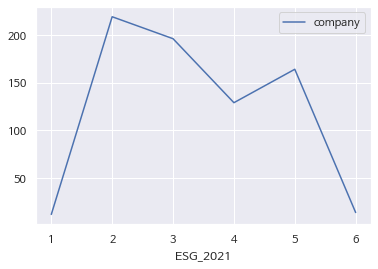

In [47]:
df_ESG[['company']].groupby(df_ESG['ESG_2021']).count().sort_values('ESG_2021', ascending=False).plot()

In [96]:
mpl.rc('font', family='NanumBarunGothic')
sns.set(font="NanumBarunGothic", rc={"axes.unicode_minus":False}, style='darkgrid')

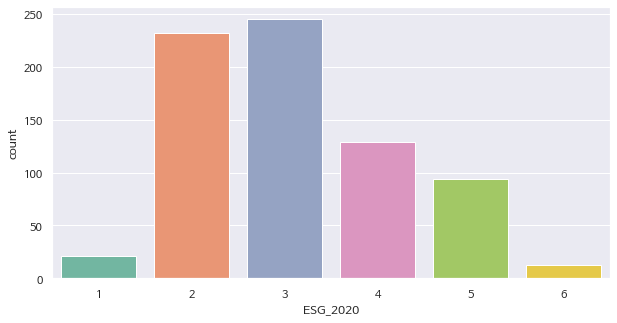

In [38]:
# 그래프의 사이즈를 조절합니다.
plt.figure(figsize=(10,5))
ax = sns.countplot(x="ESG_2020", data=df_ESG, palette="Set2")
plt.show()

Text(0.5, 1.0, 'ESG 종합등급 분포')

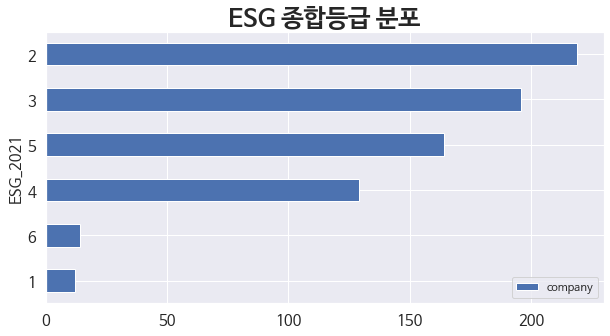

In [39]:
df_ESG[['company']].groupby(df_ESG['ESG_2021']).count().sort_values('company', ascending=True).plot.barh(figsize=(10, 5), fontsize=15)
title_style = {'fontsize': 25, 'fontweight': 'bold'}
plt.ylabel('ESG_2021', fontsize=15)
plt.title('ESG 종합등급 분포', fontdict = title_style)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

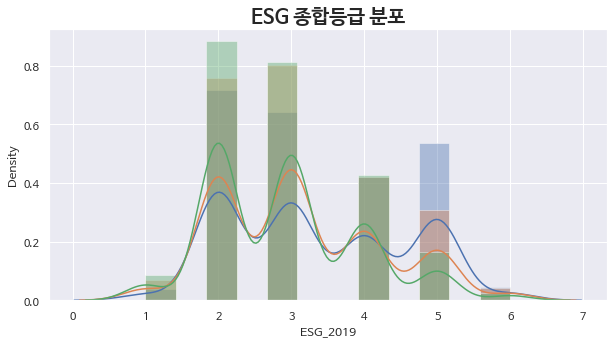

In [190]:
plt.figure(figsize=(10,5))
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('ESG 종합등급 분포', fontdict = title_style)
sns.distplot(df_ESG['ESG_2021'])
sns.distplot(df_ESG['ESG_2020'])
sns.distplot(df_ESG['ESG_2019'])

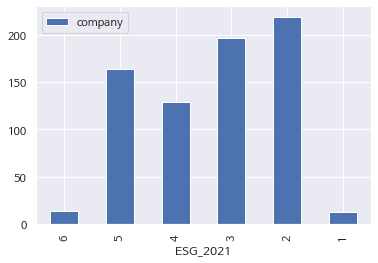

In [64]:
df_ESG[['company']].groupby(df_ESG['ESG_2021']).count().sort_values('ESG_2021', ascending=False).plot(kind='bar')

Text(0, 0.5, 'count')

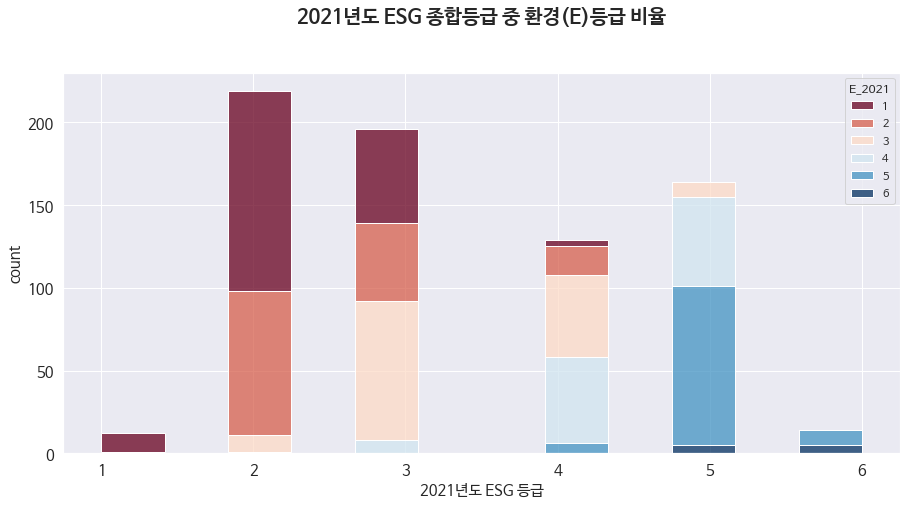

In [76]:
plt.figure(figsize=(15, 7))
ax = sns.histplot(x='ESG_2021', hue="E_2021", data=df_ESG, multiple='stack',palette='RdBu')

#set labels' font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)


for patch in ax.patches :
  height, width = patch.get_height(), patch.get_width()
  x, y = patch.get_xy()

  for i in df[['ESG_2021', 'E_2021']].index.values:
    for 
  ax.text(x + width/ 2, y+height/2, width.round(2), ha = 'center', va='center',color='white',fontsize = 10) #bar 위에 text 표시 

title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('2021년도 ESG 종합등급 중 환경(E)등급 비율',pad=50,fontdict=title_style)
plt.xlabel('2021년도 ESG 등급', fontsize=15)
plt.ylabel('count', fontsize=15)

In [409]:
#col1 : ESG_
def cross_tab_plot(col2_num, year, col1_num='ESG', df=df_ESG):
  col1 = col1_num + '_' + str(year)
  col2 = col2_num + '_' + str(year)


  cross_tab_ratio = pd.crosstab(index=df[col1], columns=df[col2], normalize='index')
  ax = cross_tab_ratio.plot( kind='bar', stacked=True, colormap='RdBu', figsize=(15, 7))
 
  #set ticklabels' style
  for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    label.set_rotation(0)

  #set labels' style
  plt.xlabel(col1, fontsize=15, labelpad=10)
  plt.ylabel(col2, fontsize=15, rotation=0, labelpad=40)
  #title
  title_style = {'fontsize': 20, 'fontweight': 'bold'}
  plt.title(f'{year}년도 ESG 종합등급 중 {col2_num}등급 비율',pad=85,fontdict=title_style)

  #legend
  legend = plt.legend(
      loc='center',
       frameon=False, #remove legend's border
       bbox_to_anchor=(0, 1.05, 1, .1), #set position (x, y, width, height)
       ncol=3, 
       borderaxespad=-.46, #remove padding(useful for removing legend's frame)
       fontsize=17)
  
  #annotation
  for patch in ax.patches :
    height, width = patch.get_height(), patch.get_width()
    x, y = patch.get_xy()
    if (height*100) < 3:
      text = ''
    else:
      text = '{:.0f}%'.format(height*100)

    ax.text(x + width/ 2, y+height/2, text, ha = 'center', va='center',color='white', fontsize = 12, fontweight='bold') 

  save_fig(f'{year}년도 ESG 종합등급 중 {col2_num}등급 비율')

그림 저장:  2019년도 ESG 종합등급 중 E등급 비율
그림 저장:  2020년도 ESG 종합등급 중 E등급 비율
그림 저장:  2021년도 ESG 종합등급 중 E등급 비율
그림 저장:  2019년도 ESG 종합등급 중 S등급 비율
그림 저장:  2020년도 ESG 종합등급 중 S등급 비율
그림 저장:  2021년도 ESG 종합등급 중 S등급 비율
그림 저장:  2019년도 ESG 종합등급 중 G등급 비율
그림 저장:  2020년도 ESG 종합등급 중 G등급 비율
그림 저장:  2021년도 ESG 종합등급 중 G등급 비율


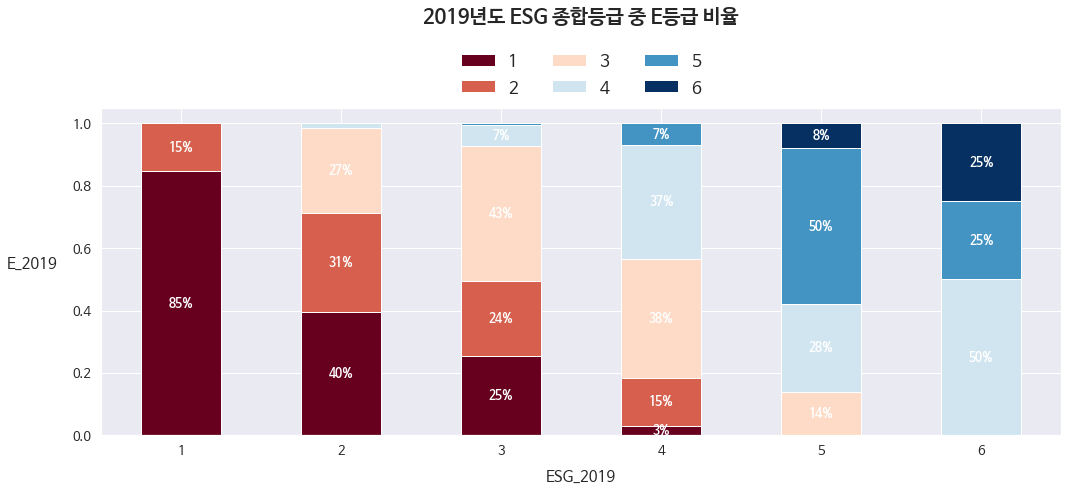

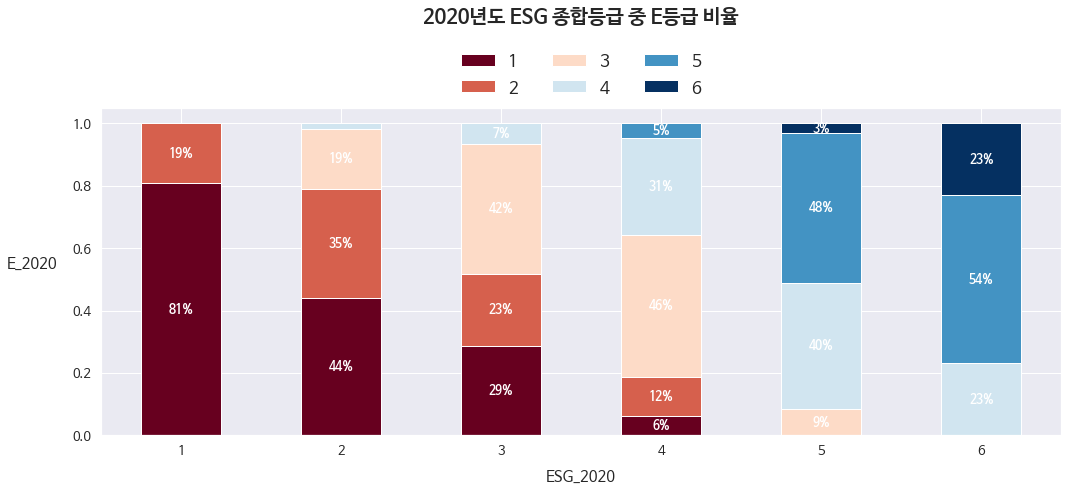

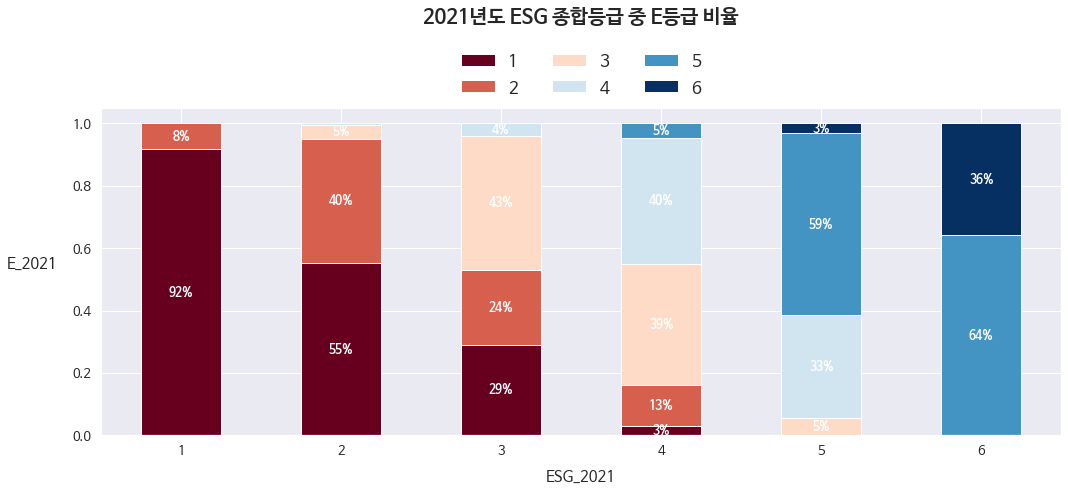

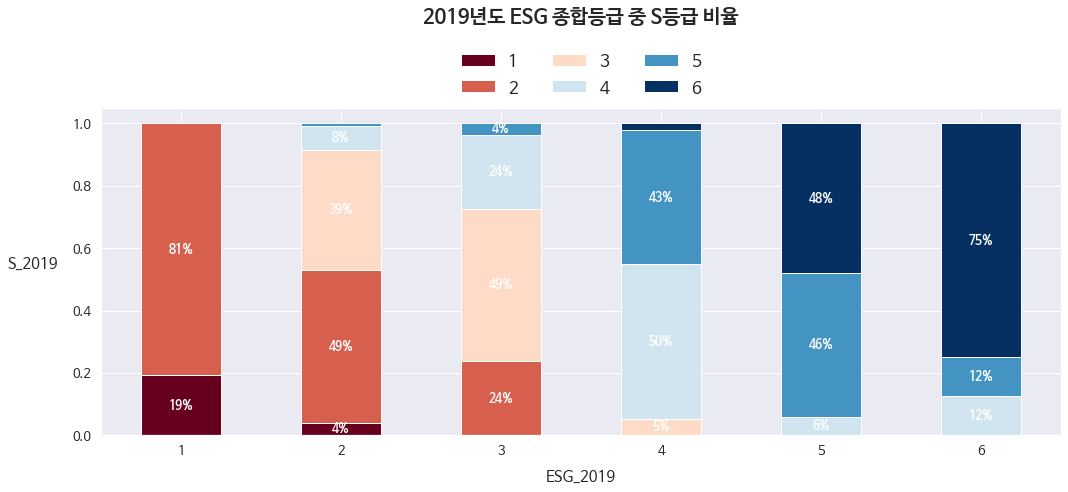

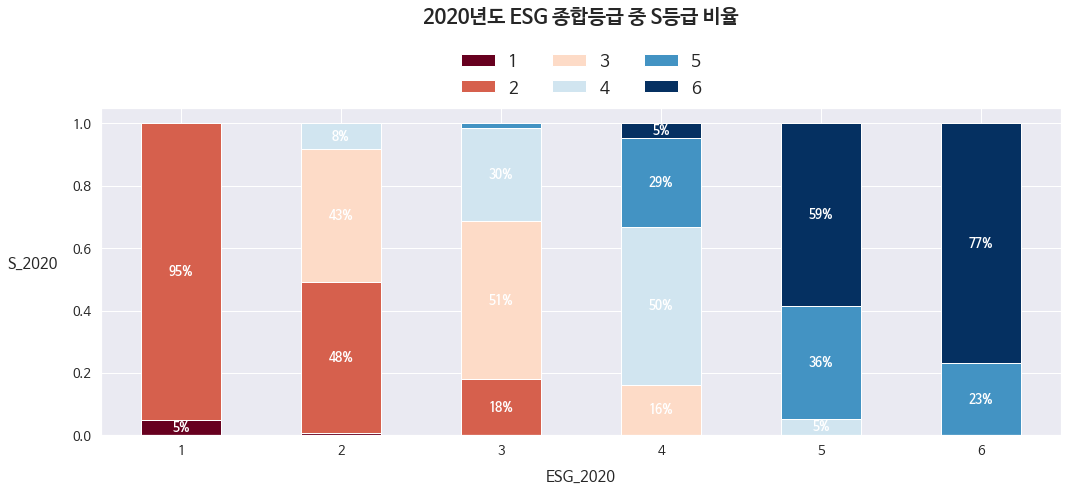

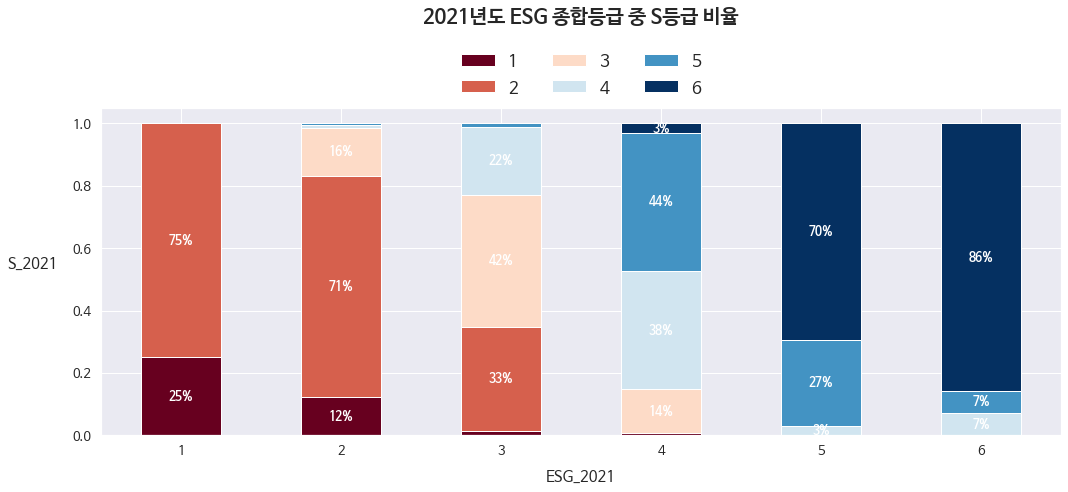

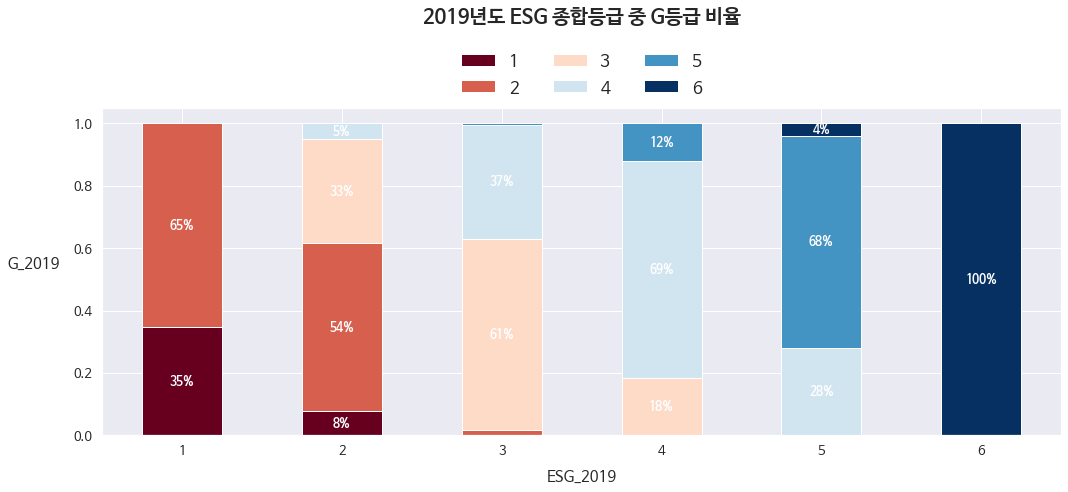

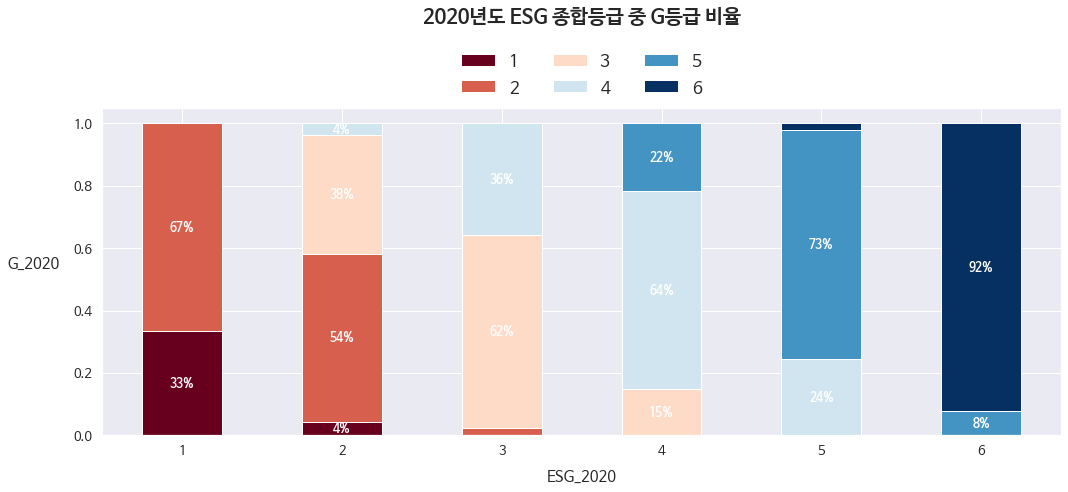

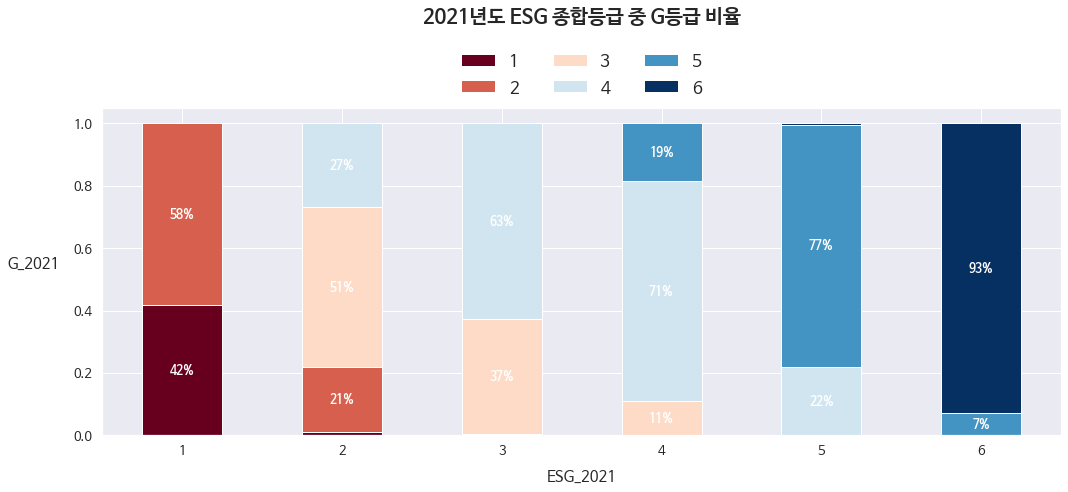

In [410]:
#각 연도/분기마다의 label 분포
label_list = ['E', 'S', 'G']
year_list = [2019, 2020, 2021]

for label in label_list:
  for year in year_list:
    cross_tab_plot(label, year)

In [205]:
cross_tab_ratio = pd.crosstab(index=df_ESG['ESG_2021'], columns=df_ESG['E_2021'], normalize='index')
cross_tab_ratio

E_2021,1,2,3,4,5,6
ESG_2021,,,,,,
1,0.916667,0.083333,0.000000,0.000000,0.000000,0.000000
2,0.552511,0.397260,0.045662,0.004566,0.000000,0.000000
3,0.290816,0.239796,0.428571,0.040816,0.000000,0.000000
4,0.031008,0.131783,0.387597,0.403101,0.046512,0.000000
5,0.000000,0.000000,0.054878,0.329268,0.585366,0.030488
6,0.000000,0.000000,0.000000,0.000000,0.642857,0.357143


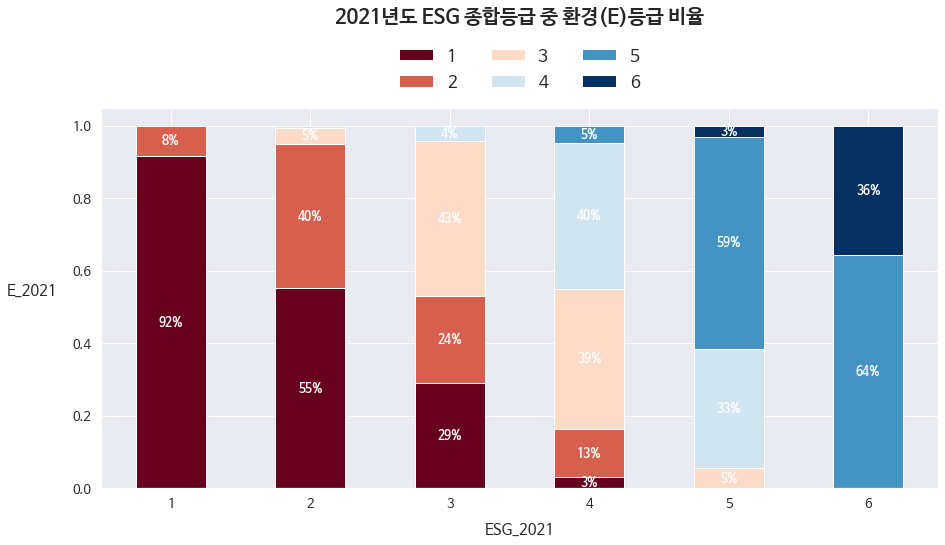

In [206]:
ax = cross_tab_ratio.plot(kind='bar', stacked=True, colormap='RdBu', figsize=(15, 7))

#set ticklabels' style
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    label.set_rotation(0)

#set labels' style
plt.xlabel('ESG_2021', fontsize=15, labelpad=10)
plt.ylabel('E_2021', fontsize=15, rotation=0, labelpad=40)

#title
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('2021년도 ESG 종합등급 중 환경(E)등급 비율',pad=85,fontdict=title_style)

#legend
legend = plt.legend(loc='center',
       frameon=False, #remove legend's border
       bbox_to_anchor=(0, 1.05, 1, .1), #set position (x, y, width, height)
       ncol=3, 
       borderaxespad=-.46, #remove padding(useful for removing legend's frame)
       fontsize=17)

#annotation
for patch in ax.patches :
  height, width = patch.get_height(), patch.get_width()
  x, y = patch.get_xy()
  if (height*100) < 3:
    text = ''
  else:
     text = '{:.0f}%'.format(height*100)
  ax.text(x + width/ 2, y+height/2, text, ha = 'center', va='center',color='white', fontsize = 12, fontweight='bold') 

Text(0, 0.5, 'count')

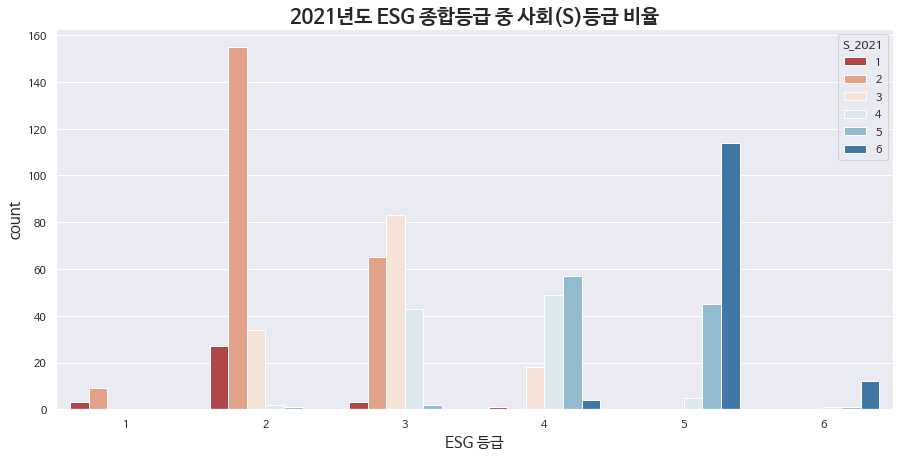

In [117]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(x="ESG_2021", data=df_ESG, hue = 'S_2021', palette="RdBu")
ax.get_xticklabels()
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('2021년도 ESG 종합등급 중 사회(S)등급 비율',fontdict=title_style)
plt.xlabel('ESG 등급', fontsize=15)
plt.ylabel('count', fontsize=15)